# Image Classification with Convolutional Neural Networks

We're going to start using some Kedro concepts to perform the first part of the previously shown notebooks.

We'll start with Kedro's DataCatalog, which provides you with an interface to load and save the data without having to worry about the underlying implementation.


## DataCatalog

In [1]:

from kedro.io import DataCatalog

The [`kedro-datasets`](https://github.com/kedro-org/kedro-plugins/tree/main/kedro-datasets) package offers connectors to load data from different formats, such as CSV, Excel, Parquet, and more. To load images, `kedro-datasets` provides a `pillow.ImageDataset` implementation that uses the `pillow` library.

In [5]:
# Define the configuration details for the ships dataset as a dictionary

catalog_config = {
    "ship_image_1": {
        "type": "pillow.ImageDataset",
        "filepath": "data/01_raw/shipsnet/shipsnet/0__20150718_184300_090b__-122.35324421973536_37.772113980272394.png",
    }
}

In [6]:
catalog = DataCatalog.from_config(catalog_config)

In [7]:
catalog.list()

['ship_image_1']

In [8]:
image = catalog.load("ship_image_1")
image.show()

Now, because our dataset contains 4000 images, it would be highly impractical to define the configuration for each image in the dictionary manually. Instead, we can use the `partitions.PartitionedDataset` from `kedro-datasets` which allows us to load files from a directory structure.

In [9]:
catalog_config = {
    "ships": {
        "type": "partitions.PartitionedDataset",
        "path": "data/01_raw/shipsnet/shipsnet",
        "dataset": {
            "type": "pillow.ImageDataset",
        }
    }
}

In [10]:
catalog = DataCatalog.from_config(catalog_config)

In [11]:
catalog.list()

['ships']

In [13]:
catalog.load('ships')

{'0__20150718_184300_090b__-122.35324421973536_37.772113980272394.png': <bound method ImageDataset._load of kedro_datasets.pillow.image_dataset.ImageDataset(filepath=PurePosixPath('/Users/ankita_katiyar/kedro_projects/kedro-image-classification/data/01_raw/shipsnet/shipsnet/0__20150718_184300_090b__-122.35324421973536_37.772113980272394.png'), protocol='file', save_args={})>,
 '0__20150718_184300_090b__-122.38458613431831_37.763521076612484.png': <bound method ImageDataset._load of kedro_datasets.pillow.image_dataset.ImageDataset(filepath=PurePosixPath('/Users/ankita_katiyar/kedro_projects/kedro-image-classification/data/01_raw/shipsnet/shipsnet/0__20150718_184300_090b__-122.38458613431831_37.763521076612484.png'), protocol='file', save_args={})>,
 '0__20150718_184300_090b__-122.40477488428849_37.8071040053892.png': <bound method ImageDataset._load of kedro_datasets.pillow.image_dataset.ImageDataset(filepath=PurePosixPath('/Users/ankita_katiyar/kedro_projects/kedro-image-classification

### Load and preprocess the data

In [16]:
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [17]:
def convert_to_np(part, num_classes=2):
    images = []
    labels = []
    for file, func in part.items():
        image = func()
        images.append(image)
        labels.append(file[:1])
    images = np.array(images, dtype=np.int64)
    labels = np.array(labels, dtype=np.int64)
    labels = to_categorical(labels, num_classes=num_classes)
    return images, labels

def split_train_test_val(images, labels, test_split, val_split, random_state):
    X_train, X_test_val, y_train, y_test_val = train_test_split(images, labels, test_size=test_split+val_split, random_state=random_state, shuffle=True, stratify=labels)
    X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=test_split/val_split, random_state=random_state, shuffle=True)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [20]:
test_size = 0.2
val_size = 0.3
random_state = 42

In [21]:
images, labels = convert_to_np(catalog.load('ships'))
X_train, X_val, X_test, y_train, y_val, y_test = split_train_test_val(images, labels, test_size, val_size, random_state)

### Visualise the data

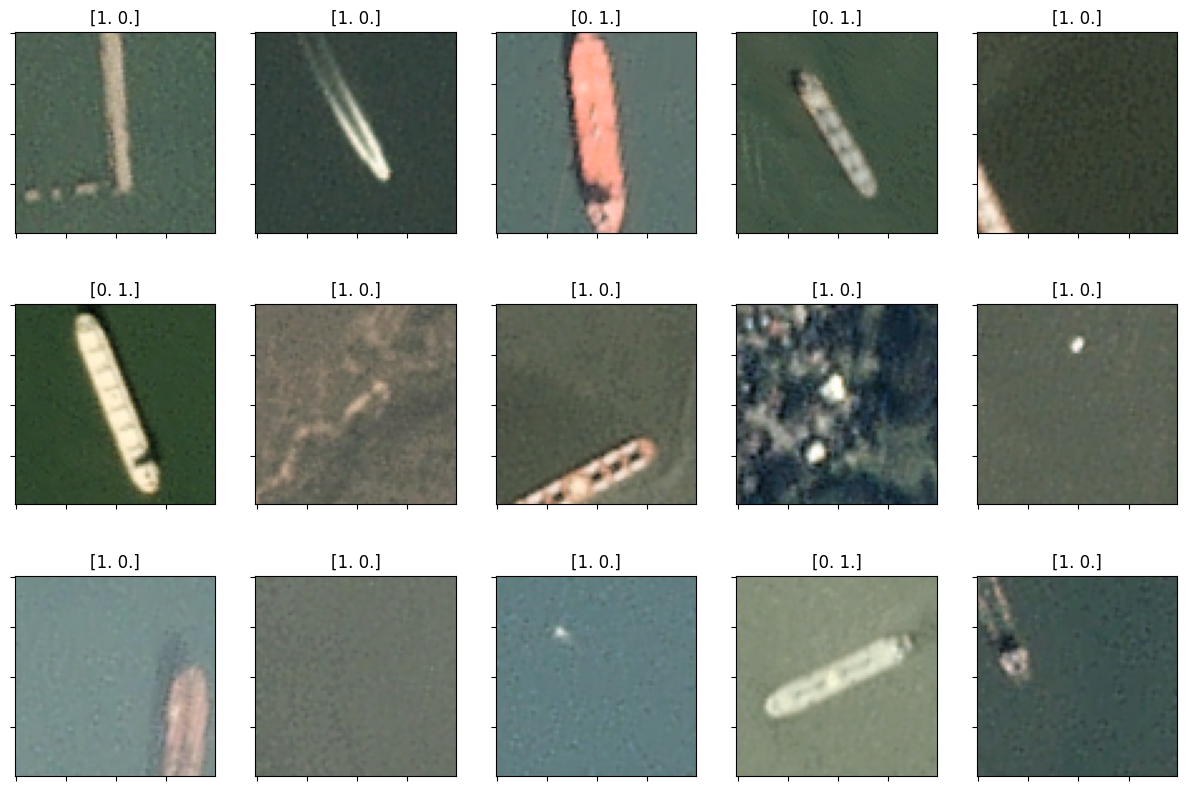

In [22]:
# Plot some sample images
import random

n_rows = 3
n_cols = 5

plt.figure(figsize=(15, 10))
for i in range(n_rows*n_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    index = random.randint(0, len(X_train) - 1)
    index
    plt.imshow(X_train[index])
    plt.title(y_train[index])

## OmegaConfigLoader

To further simplify things and separate out the configuration from the code, we can use Kedro's `OmegaConfigLoader` to load the configuration from a YAML file. This way, we can easily change the configuration without modifying the code.

`OmegaConfigLoader` expects the following folder structure for the configuration source directory:
```
conf/
    base/
        catalog.yml
        parameters.yml
    local/
        catalog.yml
        parameters.yml
    logging.yml
```

To use `OmegaConfigLoader` together with `DataCatalog`, we need to define the dataset configurations in the `catalog.yml` file and parameters in the `parameters.yml` file.

In your `conf/base/catalog.yml` file, add the following configuration:
```yaml
ships:
  type: partitions.PartitionedDataset
  path: data/01_raw/shipsnet/shipsnet
  dataset:
    type: pillow.ImageDataset
```
In your `conf/base/parameters.yml` file, add the following configuration:
```yaml
test_size: 0.1
val_size: 0.2
random_state: 42
```



In [23]:
from kedro.config import OmegaConfigLoader

In [24]:
config_loader = OmegaConfigLoader(conf_source="conf/", base_env="base", default_run_env="local")

In [30]:
catalog_config = config_loader["catalog"]

In [35]:
parameters = config_loader["parameters"]

In [36]:
catalog = DataCatalog.from_config(config_loader["catalog"])


In [33]:
catalog.list()

['ships',
 'ships_train',
 'ships_test',
 'ships_val',
 'labels_train',
 'labels_test',
 'labels_val',
 'fitted_model',
 'history',
 'accuracy_plot',
 'loss_plot']

In [37]:
images, labels = convert_to_np(catalog.load('ships'))
X_train, X_val, X_test, y_train, y_val, y_test = split_train_test_val(images, labels, parameters['test_size'], parameters['val_size'], parameters['random_state'])